## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import kagglehub

##Load and Explore Dataset

In [2]:
# Download dataset from Kaggle
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')
print('Data source import complete.')

Data source import complete.


In [3]:
# Define dataset paths
train_dir = os.path.join(msambare_fer2013_path, 'train')
test_dir = os.path.join(msambare_fer2013_path, 'test')

row, col = 48, 48
classes = 7

In [4]:
# Function to count images in each class
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = os.path.join(path, expression)
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

In [5]:
# Count images in train and test sets
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


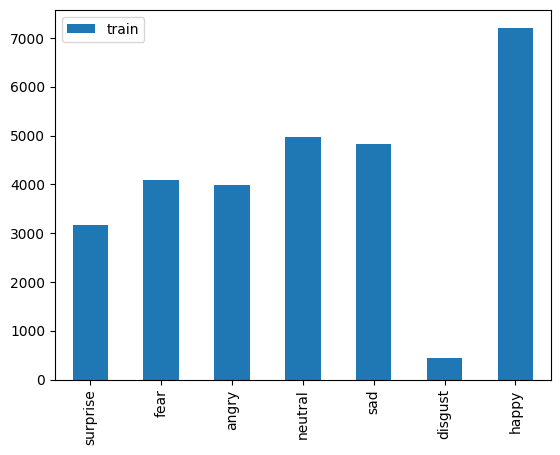

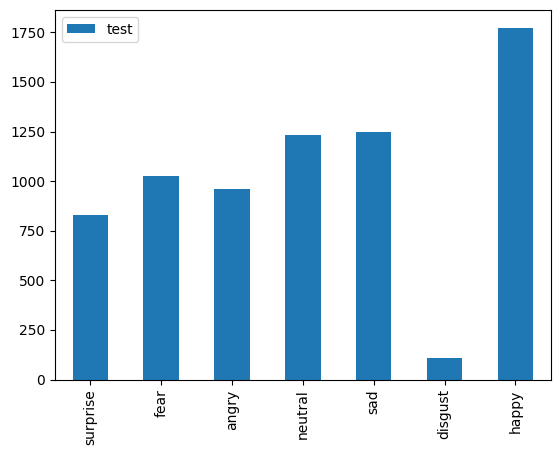

In [6]:
# Plot image counts
train_count.transpose().plot(kind='bar')
plt.show()
test_count.transpose().plot(kind='bar')
plt.show()

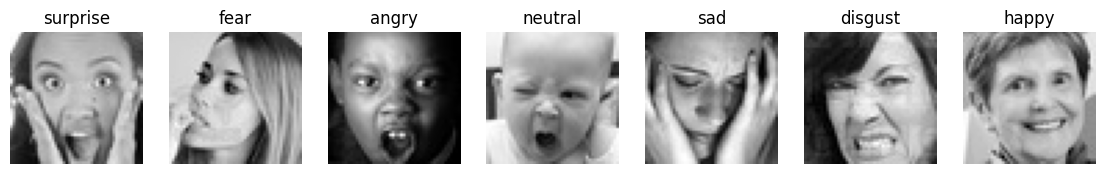

In [7]:
# Display sample images from each class
plt.figure(figsize=(14, 22))
i = 1
for expression in os.listdir(train_dir):
    img_path = os.path.join(train_dir, expression, os.listdir(os.path.join(train_dir, expression))[5])
    img = plt.imread(img_path)
    plt.subplot(1, 7, i)
    plt.imshow(img, cmap='gray')
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Prepare Data Loaders

In [8]:
# Define data transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [9]:
# Load datasets
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

In [10]:
# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [11]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [12]:
# Print class labels
class_labels = train_dataset.dataset.classes
print("Class labels:", class_labels)

Class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Define Model

In [13]:
# Define the CNN model
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        weight_decay = 1e-4
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, padding='same', bias=True),
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=4, padding='same', bias=True),
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(64, 128, kernel_size=4, padding='same', bias=True),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            nn.Conv2d(128, 128, kernel_size=4, padding='same', bias=True),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=4, padding='same', bias=True),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 128),  # Adjust based on output size after pooling
            nn.ELU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [14]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)
print(model)

EmotionCNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (4): ELU(alpha=1.0)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (9): ELU(alpha=1.0)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.3, inplace=False)
    (13): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (14): ELU(alpha=1.0)
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, a

## Define EarlyStopping and Training Function

In [15]:
# Define EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf  # Changed from np.Inf to np.inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'model_best.pth')
        self.val_loss_min = val_loss

# Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=200):
    early_stopping = EarlyStopping(patience=10, verbose=True)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load best model
    model.load_state_dict(torch.load('model_best.pth'))
    return history

## Model Training

In [16]:
# Train the model and store history
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


Epoch [1/30], Train Loss: 1.7911, Train Acc: 0.3576, Val Loss: 1.7288, Val Acc: 0.4262
Validation loss decreased (inf --> 1.728832). Saving model...
Epoch [2/30], Train Loss: 1.7154, Train Acc: 0.4388, Val Loss: 1.6762, Val Acc: 0.4828
Validation loss decreased (1.728832 --> 1.676163). Saving model...
Epoch [3/30], Train Loss: 1.6711, Train Acc: 0.4860, Val Loss: 1.6690, Val Acc: 0.4896
Validation loss decreased (1.676163 --> 1.669041). Saving model...
Epoch [4/30], Train Loss: 1.6471, Train Acc: 0.5106, Val Loss: 1.6373, Val Acc: 0.5197
Validation loss decreased (1.669041 --> 1.637256). Saving model...
Epoch [5/30], Train Loss: 1.6265, Train Acc: 0.5326, Val Loss: 1.6406, Val Acc: 0.5179
EarlyStopping counter: 1 out of 10
Epoch [6/30], Train Loss: 1.6140, Train Acc: 0.5442, Val Loss: 1.6338, Val Acc: 0.5266
Validation loss decreased (1.637256 --> 1.633828). Saving model...
Epoch [7/30], Train Loss: 1.5975, Train Acc: 0.5615, Val Loss: 1.6108, Val Acc: 0.5462
Validation loss decreased 

## Plot Loss and Accuracy

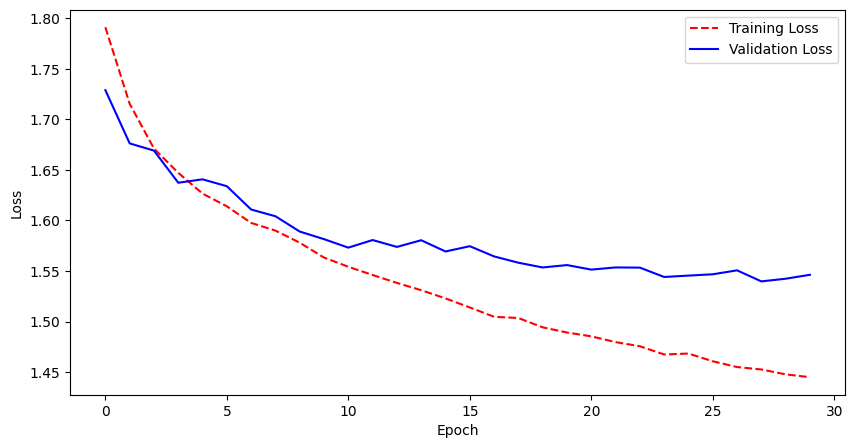

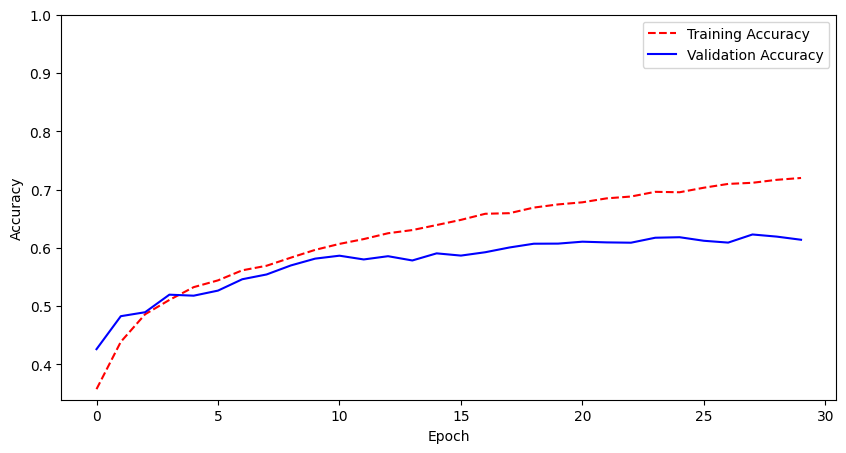

In [17]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], 'r--', label='Training Loss')
plt.plot(history['val_loss'], 'b-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], 'r--', label='Training Accuracy')
plt.plot(history['val_acc'], 'b-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top=1)
plt.legend()
plt.show()

##Save Model and Evaluate

In [18]:
# Save the model
torch.save(model.state_dict(), 'fer_model.pth')

# Evaluate model on test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print(f'Test Accuracy: {test_acc:.2f}%')

evaluate_model(model, test_loader)

Test Accuracy: 61.17%


##Confusion Matrix

Training Confusion Matrix
[[2295    0  205  142  282  270   41]
 [ 145    0   82   37   17   61    8]
 [ 325    0 2010  149  279  387  149]
 [  65    0   94 5323  146   81   50]
 [ 159    0  195  255 3022  298   36]
 [ 237    0  290  186  402 2679   30]
 [  80    0  179  122   75   55 2024]]
Training Classification Report
              precision    recall  f1-score   support

       angry       0.69      0.71      0.70      3235
     disgust       0.00      0.00      0.00       350
        fear       0.66      0.61      0.63      3299
       happy       0.86      0.92      0.89      5759
     neutral       0.72      0.76      0.74      3965
         sad       0.70      0.70      0.70      3824
    surprise       0.87      0.80      0.83      2535

    accuracy                           0.76     22967
   macro avg       0.64      0.64      0.64     22967
weighted avg       0.74      0.76      0.75     22967



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


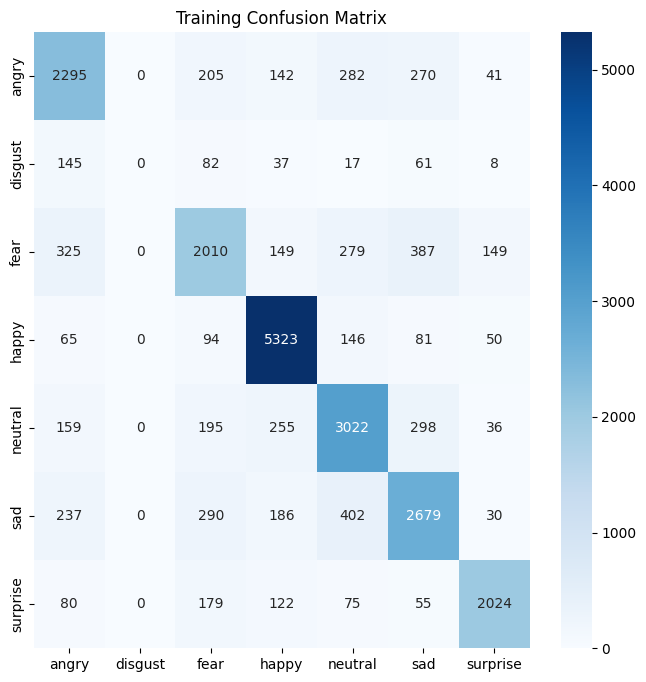

Validation Confusion Matrix
[[ 401    0   73   64  115   93   14]
 [  40    0   21    8    5   10    2]
 [ 124    0  333   45   90  142   64]
 [  38    0   33 1257   66   44   18]
 [  72    0   76   89  616  126   21]
 [ 105    0  147   59  194  493    8]
 [  30    0   95   36   24   16  435]]
Validation Classification Report
              precision    recall  f1-score   support

       angry       0.50      0.53      0.51       760
     disgust       0.00      0.00      0.00        86
        fear       0.43      0.42      0.42       798
       happy       0.81      0.86      0.83      1456
     neutral       0.55      0.62      0.58      1000
         sad       0.53      0.49      0.51      1006
    surprise       0.77      0.68      0.73       636

    accuracy                           0.62      5742
   macro avg       0.51      0.51      0.51      5742
weighted avg       0.61      0.62      0.61      5742



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


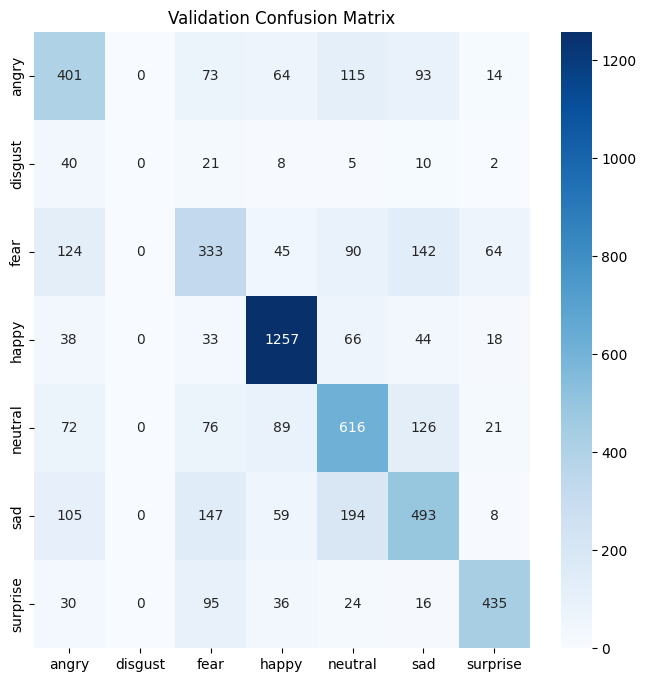

Test Confusion Matrix
[[ 548    0  101   60  108  121   20]
 [  52    0   21   17    6   14    1]
 [ 136    0  430   65  117  197   79]
 [  47    0   50 1525   77   48   27]
 [  84    0  101  118  735  175   20]
 [ 143    0  159  100  217  613   15]
 [  34    0  112   56   33   20  576]]
Test Classification Report
              precision    recall  f1-score   support

       angry       0.52      0.57      0.55       958
     disgust       0.00      0.00      0.00       111
        fear       0.44      0.42      0.43      1024
       happy       0.79      0.86      0.82      1774
     neutral       0.57      0.60      0.58      1233
         sad       0.52      0.49      0.50      1247
    surprise       0.78      0.69      0.73       831

    accuracy                           0.62      7178
   macro avg       0.52      0.52      0.52      7178
weighted avg       0.60      0.62      0.61      7178



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


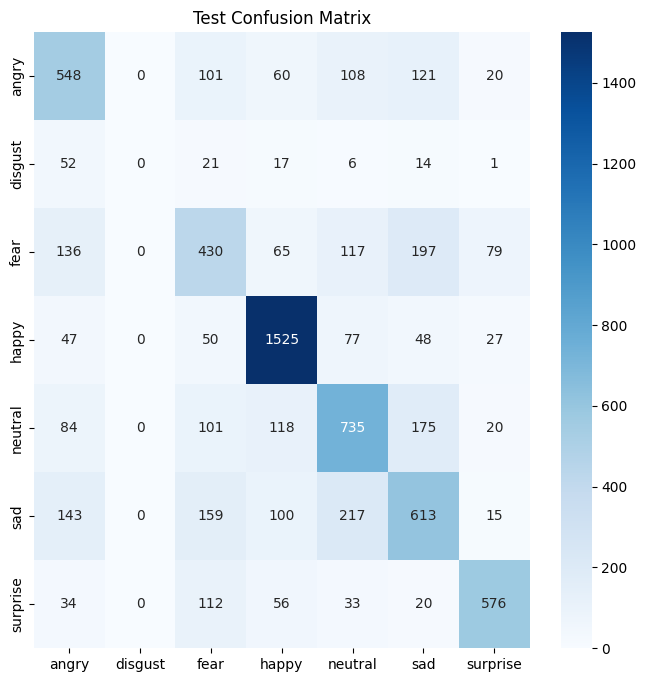

In [19]:
# Function to get predictions and labels
def get_predictions_and_labels(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Training set confusion matrix
train_preds, train_labels = get_predictions_and_labels(model, train_loader)
cm_train = confusion_matrix(train_labels, train_preds)
print('Training Confusion Matrix')
print(cm_train)
print('Training Classification Report')
print(classification_report(train_labels, train_preds, target_names=class_labels))

plt.figure(figsize=(8, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Training Confusion Matrix')
plt.show()

# Validation set confusion matrix
val_preds, val_labels = get_predictions_and_labels(model, val_loader)
cm_val = confusion_matrix(val_labels, val_preds)
print('Validation Confusion Matrix')
print(cm_val)
print('Validation Classification Report')
print(classification_report(val_labels, val_preds, target_names=class_labels))

plt.figure(figsize=(8, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Validation Confusion Matrix')
plt.show()

# Test set confusion matrix
test_preds, test_labels = get_predictions_and_labels(model, test_loader)
cm_test = confusion_matrix(test_labels, test_preds)
print('Test Confusion Matrix')
print(cm_test)
print('Test Classification Report')
print(classification_report(test_labels, test_preds, target_names=class_labels))

plt.figure(figsize=(8, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Test Confusion Matrix')
plt.show()

##Plot Predictions

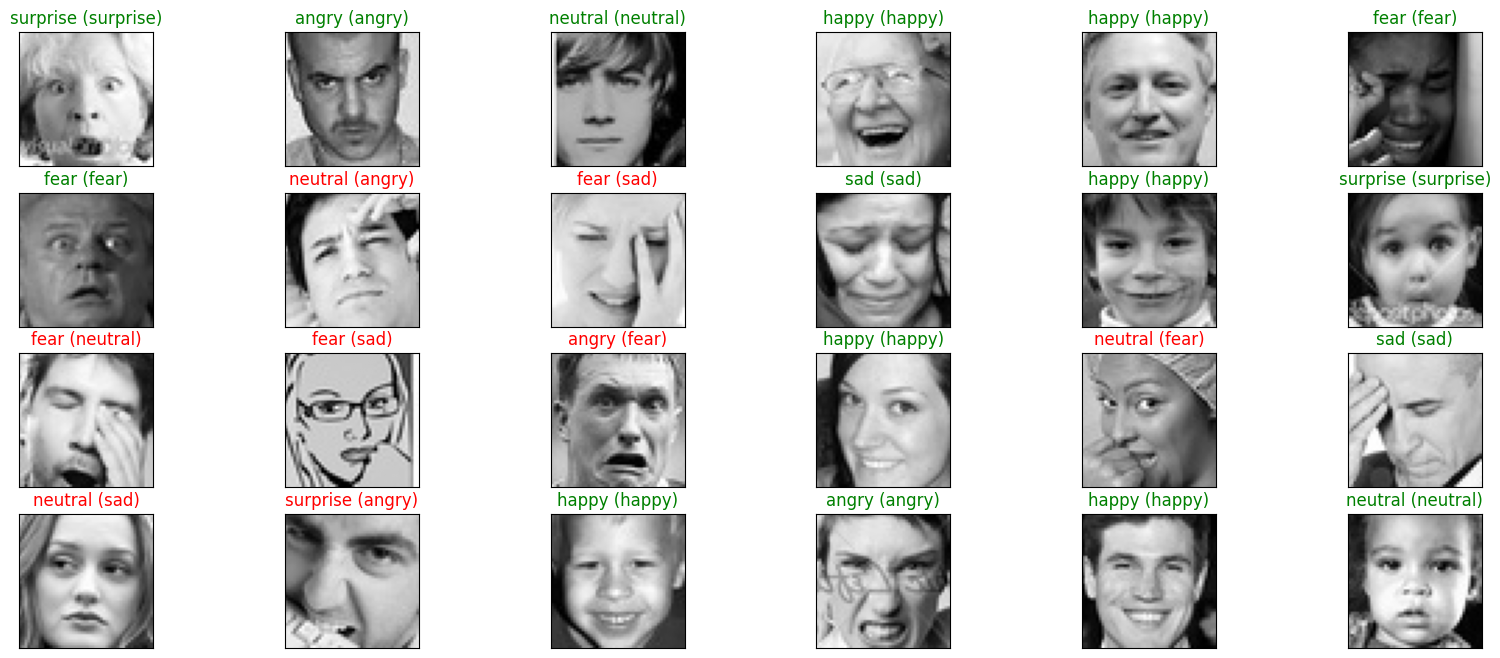

In [20]:
# Display predictions on test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(images.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(images[index].cpu().squeeze(), cmap='gray')
    predict_index = class_labels[preds[index].item()]
    true_index = class_labels[labels[index].item()]
    ax.set_title(f"{predict_index} ({true_index})",
                 color=("green" if predict_index == true_index else "red"))
plt.show()